# Classifying Earthquakes
In this notebook, I classify earthquakes using an LSTM RNN TensorFlow model. I use a dynamic RNN (a routine in TensorFlow) to create the RNN. The data is taken from the [UCR Time Series Classification Archive](http://www.cs.ucr.edu/~eamonn/time_series_data/) (Yanping Chen, Eamonn Keogh, Bing Hu, Nurjahan Begum, Anthony Bagnall, Abdullah Mueen and Gustavo Batista (2015)).

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from natsort import natsorted
from scipy import stats
from tensorflow.python.framework import ops
%matplotlib inline

## Data Preparation
### Load the Data
I load the data into Pandas DataFrames.

In [63]:
training_set = pd.read_csv('data/Earthquakes_TRAIN', sep=',')
test_validation_set = pd.read_csv('data/Earthquakes_TEST', sep=',')

In [64]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Columns: 513 entries, 0 to -0.26927.475
dtypes: float64(512), int64(1)
memory usage: 553.2 KB


In [65]:
training_set.iloc[:,0].unique()

array([1, 0])

Let's print some statistics on the training set.

In [40]:
subset0 = training_set.ix[training_set.ix[:,0] == 0, 1:].describe().T
subset1 = training_set.ix[training_set.ix[:,0] == 1, 1:].describe().T
print(subset0.loc[:,'min'].mean())
print(subset1.loc[:,'min'].mean())

-0.720507832031
-0.643048652344


## Data Exploration
Let's separate the labels and features from both the training set and test/validation set. I can then investigate trends for each data set.

In [41]:
X_train = training_set.iloc[:,1:]
y_train = training_set.iloc[:,0]

In [42]:
X_test_validation = test_validation_set.iloc[:,1:]
y_test_validation = test_validation_set.iloc[:,0]

In [43]:
unique_training_classes =  y_train.unique().tolist()
print("There are {} unique training classes, which are {}.".format(len(unique_training_classes), unique_training_classes))

There are 2 unique training classes, which are [1, 0].


In [44]:
unique_test_validation_classes =  y_test_validation.unique().tolist()
print("There are {} unique test classes, which are {}.".format(len(unique_test_validation_classes), unique_test_validation_classes))

There are 2 unique test classes, which are [0, 1].


Good, all classes in the training and test sets are in agreement, as expected. Now, let's investigate the number of unique classes for each data set.

In [45]:
print("In the training set, there are {} '0' classes and {} '1' classes.".format(len(y_train[y_train == 0]), len(y_train[y_train == 1])))

In the training set, there are 103 '0' classes and 35 '1' classes.


In [46]:
print("In the test/validation set, there are {} '0' classes and {} '1' classes.".format(len(y_test_validation[y_test_validation == 0]), len(y_test_validation[y_test_validation == 1])))

In the test/validation set, there are 264 '0' classes and 57 '1' classes.


There is an unequal number of entries between the two different classes. This could be problematic during the modeling phase as it could lead to a bias. I will address this issue duing data preparation below.

### Data Visualization
Let's plot a row of the training set and view what the data looks like.

0.000600000000004


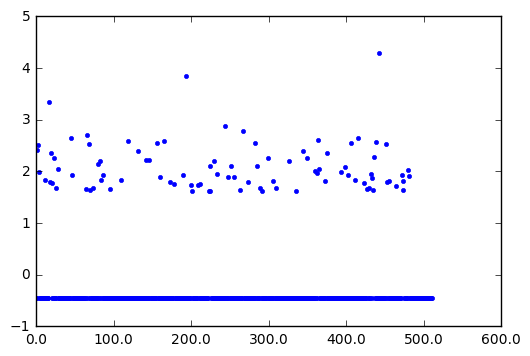

0.000479999999973


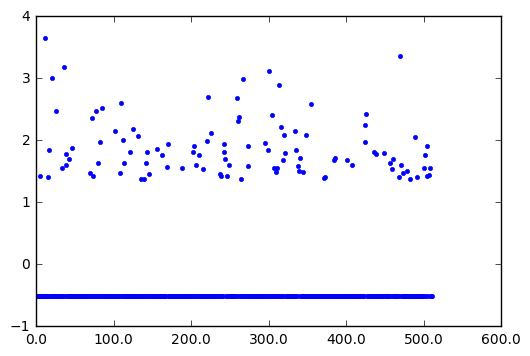

In [66]:
def plot_first_row(df, label):
    subset = df.ix[df.ix[:,0] == label, 1:]
    subset.index = np.arange(len(subset))
    x = np.arange(subset.shape[1])
    y = subset.iloc[1,0:]
    print(y.sum())
    
    tick_format = StrMethodFormatter('{x:.1f}')
    
    fig, ax = plt.subplots()
    plt.plot(x, y, 'b.')
    ax.xaxis.set_major_formatter(tick_format)
    plt.show()
    
plot_first_row(training_set, 0)
plot_first_row(training_set, 1)

Let's separate the training set by label and plot the mean time series for each DataFrame

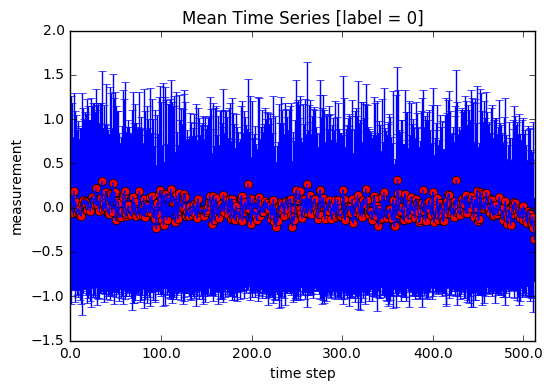

Label 0: mean of means = -4.031e-08 +/- 9.991e-02


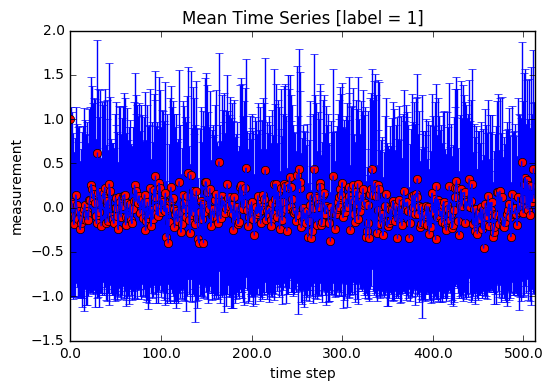

Label 1: mean of means = 1.949e-03 +/- 1.774e-01


In [48]:
def plot_mean(df, label):
    subset = df.ix[df.ix[:,0] == label, 0:]
    subset.index = np.arange(len(subset))
    x = np.arange(subset.shape[1])
    y = subset.mean().values
    yerr = np.sqrt(subset.var().values)
    
    tick_format = StrMethodFormatter('{x:.1f}')
    
    fig, ax = plt.subplots()
    plt.plot(x, y, 'ro')
    plt.errorbar(x, y, yerr=yerr)
    ax.xaxis.set_major_formatter(tick_format)
    plt.xlim([0, len(x)])
    plt.xlabel('time step')
    plt.ylabel('measurement')
    plt.title('Mean Time Series [label = {}]'.format(label))
    plt.show()
    
    mean_of_means = y.mean()
    stdev_of_means = np.sqrt(y.var())
    
    print("Label {}: mean of means = {:4.3e} +/- {:4.3e}".format(label, mean_of_means, stdev_of_means))

plot_mean(training_set, 0)
plot_mean(training_set, 1)

**Observations:** The large error bars compared to the spread in `y` indicate that there is no overlying trend for the time series. In other words, each time series is unique.  

### Fourier Analysis
I will use a Fourier transform to see if any of the time series show any periodicity.

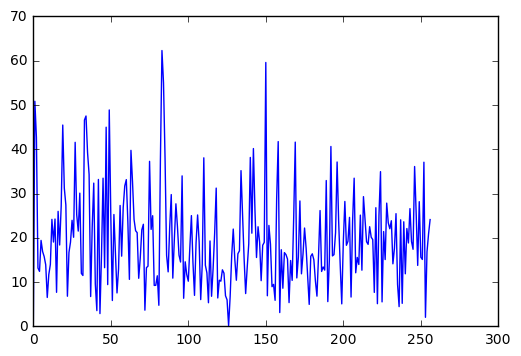

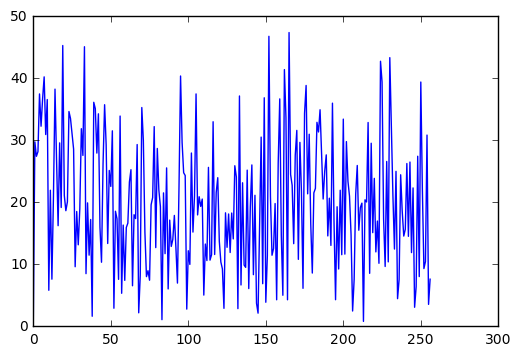

In [49]:
# Compute the FFT for the first row in the training set and plot it
def fft_first_row(df, label):
    subset = df.ix[df.ix[:,0] == label, :]
    subset.index = np.arange(len(subset))
    rfft = np.abs(np.fft.rfft(subset.ix[0,:]))
    x = np.arange(len(rfft))
    
    fix, ax = plt.subplots()
    plt.plot(x, rfft)
    plt.show()
    
fft_first_row(training_set, 0)
fft_first_row(training_set, 1)

/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


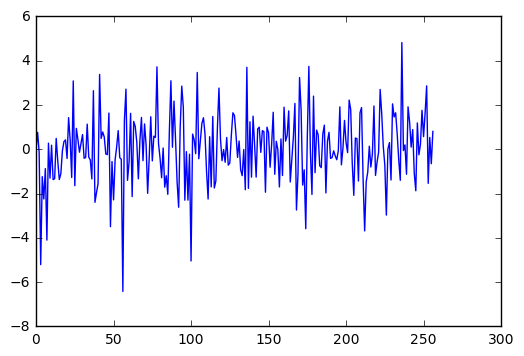

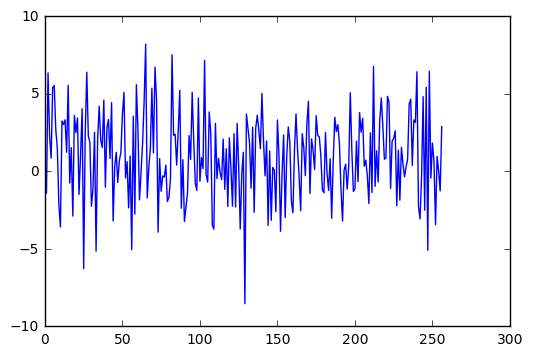

In [50]:
# Compute mean FFT for time series by label
def plot_mean_fft(df, label):
    subset = df.ix[df.ix[:,0] == label, :]
    subset.index = np.arange(len(subset))
    matrix = subset.as_matrix()
    
    rfft_list = []
    for r in matrix:
        rfft = np.fft.rfft(r)
        rfft_list.append(rfft)
    
    mean_rfft = np.array(rfft_list).mean(axis=0)
    x = np.arange(len(mean_rfft))
    
    fig, ax = plt.subplots()
    plt.plot(x, mean_rfft)
    plt.show()
    
plot_mean_fft(training_set, 0)
plot_mean_fft(training_set, 1)

/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


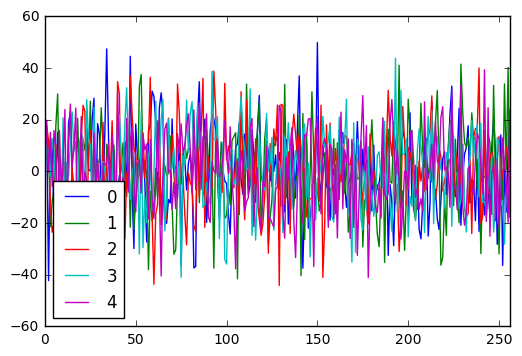

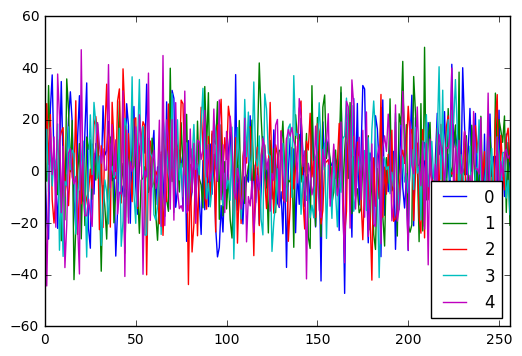

In [51]:
# Compute FFT for time series by label for each, plot all rows on same plot
def plot_all_rows_fft(df, label):
    subset = df.ix[df.ix[:,0] == label, :]
    subset.index = np.arange(len(subset))
    matrix = subset.as_matrix()
    
    rfft_list = []
    for r in matrix:
        rfft = np.fft.rfft(r)
        rfft_list.append(rfft)
    
    df_rfft = pd.DataFrame(rfft_list).head().T
    # df_rfft.info()
    df_rfft.plot()
    
plot_all_rows_fft(training_set, 0)
plot_all_rows_fft(training_set, 1)

None of the FFT plots show peaks. This indicates that there is no periodicity in the time series.

### Positive Values
I now explore wheather there is a relationship between the number of positive measurements in a time series and the corresponding label for that time series.

In [52]:
# Compute number of values greater than zero per time series for each label
def num_positives(df):
    
    positives_list = [[], []]
    mean_list = []
    labels = [0, 1]
    for l in labels:
        subset = df.ix[df.ix[:,0] == l, :]
        subset.index = np.arange(len(subset))
        for i in range(len(subset)):
            positive_values = subset.ix[i,0:] > 0
            sum_positives = np.sum(positive_values)
            positives_list[l].append(sum_positives)

        mean_positives = np.array(positives_list[l]).mean()
        mean_list.append(mean_positives)
        stdev_positives = np.sqrt(np.array(positives_list[l]).var())
        print("For label {} the mean number of positive values is {:.3f} +/- {:.3f}.".format(l, 
                                                                                     mean_positives, 
                                                                                     stdev_positives))
        print(" - mean fraction of positive values = {:.3f}".format(mean_positives / subset.shape[1]))
    tstatistic = stats.ttest_1samp(positives_list[0], mean_list[1]).statistic
    pvalue = stats.ttest_1samp(positives_list[0], mean_list[1]).pvalue
    print("t-statistic = {:.3f}, pvalue = {:.3e}".format(tstatistic, pvalue))
num_positives(training_set)

For label 0 the mean number of positive values is 90.592 +/- 37.879.
 - mean fraction of positive values = 0.177
For label 1 the mean number of positive values is 111.800 +/- 23.035.
 - mean fraction of positive values = 0.218
t-statistic = -5.655, pvalue = 1.432e-07


**Observation:** This analysis indicates that on average label 1 has more positive measurements than label 0 and that there is a statistically significant difference between these two labels.

## Data Preparation
I am interested in the distribution of positive values as related to their label. Per time range, there apears to be more positives values for label 1 than label 0. I would like to see if TensorFlow can identify this trend as well and properly label the time series.

### Negative values
Since I am not interested in the values themselves, I will set all negative values to zero.

In [53]:
mask = training_set.ix[:,1:] <= 0
mask.ix[:,4].unique()

array([True, False], dtype=object)

In [54]:
training_set[mask].head()

,0,-0.26927,-0.26927.1,-0.26927.2,-0.26927.3,-0.26927.4,3.1369,-0.26927.5,-0.26927.6,2.9842,...,-0.26927.466,-0.26927.467,-0.26927.468,-0.26927.469,-0.26927.470,-0.26927.471,-0.26927.472,-0.26927.473,-0.26927.474,-0.26927.475
0,NaN,-0.46887,NaN,NaN,-0.46887,-0.46887,-0.46887,-0.46887,-0.46887,NaN,...,-0.46887,NaN,-0.46887,NaN,-0.46887,-0.46887,-0.46887,-0.46887,NaN,-0.46887
1,NaN,NaN,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,NaN,...,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296,-0.39296
2,NaN,-0.45836,NaN,-0.45836,NaN,NaN,-0.45836,-0.45836,-0.45836,-0.45836,...,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836,-0.45836
3,NaN,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,...,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609,-0.58609
4,NaN,NaN,-0.44769,-0.44769,-0.44769,NaN,-0.44769,NaN,-0.44769,-0.44769,...,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769,-0.44769


In [69]:
mask_negatives_train = training_set.ix[:,1:] <= 0
mask_negatives_test_val = test_validation_set.ix[:,1:] <= 0
training_set[mask_negatives_train] = 0
test_validation_set[mask_negatives_test_val] = 0

### Positive values
Likewise, I will set all positive values to 1.

In [70]:
mask_positives_train = training_set.ix[:,1:] > 0
mask_positives_test_val = test_validation_set.ix[:,1:] > 0
training_set[mask_positives_train] = 1
test_validation_set[mask_positives_test_val] = 1

92.0


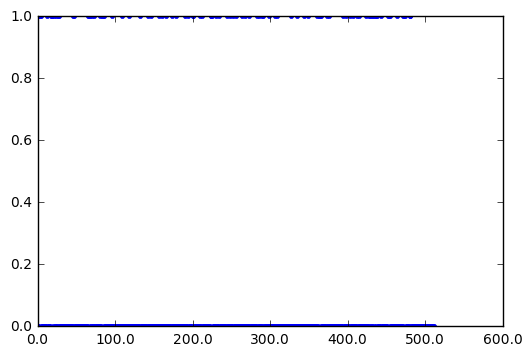

108.0


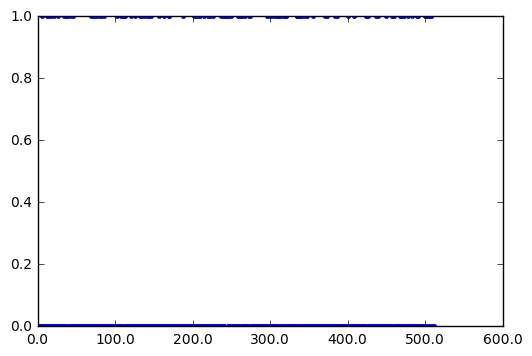

In [71]:
plot_first_row(training_set, 0)
plot_first_row(training_set, 1)

### Evenly split labels.
Here I define a function to randomly choose values from the larger of the two classes and produce a dataset with equal quantities of both classes. This will be done for both the train set and test set.

In [72]:
def random_data_split(df):
    
    classes = df.iloc[:,0]
    unique_classes = classes.unique()
    
    number_of_classes_list = []
    for c in unique_classes:
        number_of_classes = len(classes[classes == c])
        number_of_classes_list.append(number_of_classes)
        
    smallest_class_index = np.argmin(np.array(number_of_classes_list))
    smallest_class = unique_classes[smallest_class_index]
    
    # Store smallest class in a DataFrame
    smallest_class_mask = (df.iloc[:,0] == smallest_class).tolist()
    df_small = df.iloc[smallest_class_mask,:]
    smallest_class_size = len(df_small)
    
    # Select only classes larger than the smallest class
    larger_classes = unique_classes[unique_classes != smallest_class]
    larger_classes_mask = (df.iloc[:,0] != smallest_class).tolist()
    df_larger = df.iloc[larger_classes_mask,:]
    
    # Loop through the larger classes and select a random set of size equal to the smallest class size
    for lc in larger_classes:
        class_mask = (df_larger.iloc[:,0] == lc).tolist()
        df_get_class = df_larger.iloc[class_mask,:]
        df_sample = df_get_class.sample(n=smallest_class_size)
        df_small = df_small.append(df_sample)
    
    return df_small

In [73]:
training_set_resampled = random_data_split(training_set)
new_training_index = np.arange(len(training_set_resampled))
training_set_resampled = training_set_resampled.set_index(new_training_index).copy()

In [74]:
y_training_resampled = training_set_resampled.iloc[:,0]
unique_training_labels_resampled = y_training_resampled.unique()

for c in unique_training_labels_resampled:
    label_count = len(y_training_resampled[y_training_resampled == c])
    print('There are {} entries for class {} in the training set.'.format(label_count, c))

There are 35 entries for class 1 in the training set.
There are 35 entries for class 0 in the training set.


In [75]:
test_validation_set_resampled = random_data_split(test_validation_set)
new_test_validation_index = np.arange(len(test_validation_set_resampled))
test_validation_set_resampled = test_validation_set_resampled.set_index(new_test_validation_index).copy()

In [76]:
y_test_validation_resampled = test_validation_set_resampled.iloc[:,0]
unique_test_validation_labels_resampled = y_test_validation_resampled.unique()

for c in unique_test_validation_labels_resampled:
    label_count = len(y_test_validation_resampled[y_test_validation_resampled == c])
    print('There are {} entries for class {} in the test/validation set.'.format(label_count, c))

There are 57 entries for class 1 in the test/validation set.
There are 57 entries for class 0 in the test/validation set.


Good. Now I have a way to ensure that each class is represented equally in the analysis.

### Split test_validation_set into test_set and validation_set
Now I split the test_validation_set equally into a test_set and validation_set. The validation_set will be used to test the model accuracy during training, while the test_set will be used to measure the final model accuracy.

In [77]:
split_index = len(test_validation_set_resampled) // 2
test_set_resampled = test_validation_set_resampled.iloc[0:split_index,:].copy()
validation_set_resampled = test_validation_set_resampled.iloc[split_index:,:].copy()
new_validation_set_resampled_index = np.arange(len(validation_set_resampled))
validation_set_resampled = validation_set_resampled.set_index(new_validation_set_resampled_index).copy()

## Model Preparation

In [132]:
# Function to take a random batch of data from the training set
def make_batch(full_training_set, batch_size, back_prop_steps):
    
    num_rows, num_columns = full_training_set.shape
    
    bp_start_i = np.random.choice(num_columns-back_prop_steps,1)[0]
    bp_end_i = bp_start_i + back_prop_steps
    
    random_batch = full_training_set.sample(n=batch_size)
    
    X_batch = random_batch.iloc[0:,bp_start_i:bp_end_i]
    y_batch = random_batch.iloc[:,0].values
    # y_batch = np.array([y_batch_array]*back_prop_steps)
    
    return X_batch, y_batch

In [79]:
# Function to print hyperparameters to a directory
def save_hyperparameters(hyperparam_dict, training_step_list, final_accuracy):
    
    cwd = os.getcwd()
    fpath = cwd+'/tmp/params'
    try:
        dirlist = os.listdir(fpath)
        dirlist_parsed = [x.split('_') for x in dirlist]
        dirlist_parsed_prefix = [x.split('_')[0] for x in dirlist]
        dirlist_parsed_suffix = [x.split('_')[-1] for x in dirlist]

        dirarray = np.array(dirlist)
        dirarray_parsed_prefix = np.array(dirlist_parsed_prefix)
        dirarray_sorted_suffix = np.array(natsorted(dirlist_parsed_suffix))
    
        num_run_dirs = np.sum(dirarray_parsed_prefix == 'run')
    
    except FileNotFoundError:
        os.mkdir(fpath)
        num_run_dirs = 0

    # Check if run_1 directory exisits
    if num_run_dirs == 0:
        next_run_directory = '/run_1'
    else:
        previous_run_number = np.int(dirarray_sorted_suffix[-1])
        next_run = previous_run_number + 1
        next_run_string = np.str(next_run)
        next_run_directory = '/run_'+next_run_string
        
    os.mkdir(fpath+next_run_directory)    
    fo = open(fpath+next_run_directory+'/hyperparameters.txt', "w")
    for key, value in hyperparam_dict.items():
        fo.write(key+': '+np.str(value)+'\n')
    fo.write('\n')
    for list_item in training_step_list:
        fo.write(list_item+'\n')
    fo.write("The final accuracy is {:3f}.".format(final_accuracy))
    fo.close()
    
    print('Saving hyperparameters to tmp/params{}/'.format(next_run_directory))

In [80]:
# Function to print parameters to a directory
def create_log_directory():
    
    cwd = os.getcwd()
    fpath = cwd+'/tmp/logs'
    try:
        dirlist = os.listdir(fpath)
        dirlist_parsed = [x.split('_') for x in dirlist]
        dirlist_parsed_prefix = [x.split('_')[0] for x in dirlist]
        dirlist_parsed_suffix = [x.split('_')[-1] for x in dirlist]

        dirarray = np.array(dirlist)
        dirarray_parsed_prefix = np.array(dirlist_parsed_prefix)
        dirarray_sorted_suffix = np.array(natsorted(dirlist_parsed_suffix))
    
        num_run_dirs = np.sum(dirarray_parsed_prefix == 'run')
    
    except FileNotFoundError:
        os.mkdir(fpath)
        num_run_dirs = 0

    # Check if run_1 directory exisits
    if num_run_dirs == 0:
        os.mkdir(fpath+'/run_1')
        log_directory = 'tmp/logs/run_1'
    else:
        previous_run_number = np.int(dirarray_sorted_suffix[-1])
        next_run = previous_run_number + 1
        next_run_string = np.str(next_run)
        next_run_directory = '/run_'+next_run_string
        os.mkdir(fpath+next_run_directory)
        log_directory = 'tmp/logs/run_'+next_run_string

    print('Saving summaries to '+log_directory+'/')    
        
    return log_directory

### Define the hyperparameters
Organized in dictionary to allow easy logging of values while searching for best model parameters.

In [100]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

In [230]:
# Define the hyperparameters
hyperparam_dict = dict(
    number_of_classes = len(unique_training_labels_resampled),
    batch_size = 14,
    back_prop_steps = 100,
    lstm_layers = 1,
    lstm_cell_units = 5,
    drop_out = 0.8,
    clipping_ratio = 5,
    learning_rate = 1e-4,
    training_iterations = 2000
)

In [231]:
# Define TensorFlow placeholders
X = tf.placeholder(tf.int32,
                   [None, hyperparam_dict['back_prop_steps']],
                   name = 'Features')
y = tf.placeholder(tf.int64,
                   [None], 
                   name='Labels')
print('y: {}'.format(y))
keep_probability = tf.constant(hyperparam_dict['drop_out'])

# Expand dimensions of features placeholder
X_expanded = tf.expand_dims(X, 2)
print('X_expanded: {}'.format(X_expanded))

# Reshaped labels placeholder
y_reshaped = tf.reshape(y, [-1])
print('y_reshaped: {}'.format(y_reshaped))

y: Tensor("Labels:0", shape=(?,), dtype=int64)
X_expanded: Tensor("ExpandDims:0", shape=(?, 100, 1), dtype=int32)
y_reshaped: Tensor("Reshape:0", shape=(?,), dtype=int64)


### Create the LSTM cell
This includes dropout and multiple layers.

In [232]:
def create_lstm_cell(number_of_classes, back_prop_steps, lstm_cell_units, keep_probability, lstm_layers, batch_size, X):
    print('create_lstm_cell:')
    embeddings = tf.get_variable('embedding_matrix', [number_of_classes, back_prop_steps])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, X)
    print('    rnn_inputs: {}'.format(rnn_inputs))
    cell = tf.nn.rnn_cell.LSTMCell(lstm_cell_units, state_is_tuple=True)
    print('    LSTMCell: {}'.format(cell))
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_probability)
    print('    DropoutWrapper: {}'.format(cell))
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * lstm_layers, state_is_tuple=True)
    print('    MultiRNNCell: {}'.format(cell))
    cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_probability)
    print('    DroputWrapper: {}'.format(cell))
    init_state = cell.zero_state(batch_size, tf.float32)
    cell_outputs, state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    print('    cell_outputs: {}'.format(cell_outputs))
    # cell_outputs = tf.reshape(cell_outputs, [-1, lstm_cell_units])
    # print('    cell_outputs: {}'.format(cell_outputs))
    cell_outputs_packed = tf.pack(cell_outputs)
    print('    cell_outputs_packed: {}'.format(cell_outputs_packed))
    cell_outputs_averaged = tf.reduce_mean(cell_outputs_packed, 0)
    print('    cell_outputs_averaged: {}'.format(cell_outputs_averaged))
    
    return cell_outputs_averaged, state

### Create the softmax layer
The LSTM cells will be placed in a softmax layer. This will allow the RNN to learn categorical data.

In [233]:
def softmax_layer(lstm_cell_units, number_of_classes, cell_outputs):
    print('softmax_layer:')
    W = tf.Variable(tf.truncated_normal([lstm_cell_units, number_of_classes], 
                                        stddev=1.0), 
                    name='weights', dtype=tf.float32, trainable=True)
    b = tf.Variable(tf.zeros([number_of_classes]), 
                    name='biases', dtype=tf.float32, trainable=True)
    cell_outputs_X_W = tf.matmul(cell_outputs, W, name='multiply')
    print('    cell_outputs_X_W: {}'.format(cell_outputs_X_W))
    logits = tf.add(cell_outputs_X_W, b, name='add')
    print('    logits: {}'.format(logits))
    
    return logits

### Define the cost function

In [234]:
def define_cost_function(logits, y, batch_size):
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y, 
                                                          name='cross_entropy')
    cost = tf.reduce_mean(loss) / batch_size
    
    return cost

### Create the training step

In [235]:
def train(cost, learning_rate, clipping_ratio):
    training_variables = tf.trainable_variables()
    computed_gradientes = tf.gradients(cost, training_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(computed_gradientes, 
                                                  clipping_ratio)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = list(zip(clipped_gradients, training_variables))
    training_step = optimizer.apply_gradients(gradients)
    # Create histograms for variables, gradients and gradient norms. Plots displayed in TensorBoard.
    for gradient, variable in gradients:
        if isinstance(gradient, ops.IndexedSlices):
            gradient_values = gradient.values
        else:
            gradient_values = gradient
        tf.histogram_summary(variable.name, variable)
        tf.histogram_summary(variable.name + "/gradients", gradient_values)
        tf.histogram_summary(variable.name + "/gradient_norm", 
                             tf.global_norm([gradient_values]))

    return training_step

### Check model accuracy during training

In [236]:
def check_model_accuracy(logits, y):
    correct_prediction = tf.equal(tf.argmax(logits,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), 
                              name='accuracy')
    
    return accuracy

### Compute the final model accuracy

In [237]:
# Function to compute final model accuracy
def compute_final_accuracy(test_set, batch_size, back_prop_steps):
    test_rows = test_set.shape[0]
    number_of_batches = np.floor(test_rows/batch_size)
    test_accuracy = np.zeros(number_of_batches)
    for i in range(int(number_of_batches)):
        X_batch, y_batch = make_batch(test_set, batch_size, back_prop_steps)
        X_batch_expanded = np.expand_dims(X_batch, axis=2)
        # y_batch_reshaped = y_batch  # np.ravel(y_batch)
        test_accuracy[i] = sess.run(accuracy, 
                                    feed_dict = {X_expanded: X_batch_expanded, 
                                                 y: y_batch,
                                                 keep_probability: 1})
    
    return np.mean(test_accuracy)

## Setup the TensorFlow Graph
Now that we have defined the functions needed for the TensorFlow graph, we can create it.

In [238]:
# Create LSTM Cell
with tf.name_scope("LSTM") as scope:
    cell_outputs, state = create_lstm_cell(hyperparam_dict['number_of_classes'], 
                                           hyperparam_dict['back_prop_steps'],
                                           hyperparam_dict['lstm_cell_units'],
                                           keep_probability, 
                                           hyperparam_dict['lstm_layers'], 
                                           hyperparam_dict['batch_size'], 
                                           X)

# Create softmax layer
with tf.name_scope("softmax_layer") as scope:
    logits = softmax_layer(hyperparam_dict['lstm_cell_units'], 
                           hyperparam_dict['number_of_classes'], 
                           cell_outputs)

# Define cost function
with tf.name_scope("cost_function") as scope:
    cost = define_cost_function(logits, 
                                y, 
                                hyperparam_dict['batch_size'])
    tf.scalar_summary("cost", cost)

# Define training step
with tf.name_scope("training") as scope:
    training_step = train(cost, 
                          hyperparam_dict['learning_rate'], 
                          hyperparam_dict['clipping_ratio'])

# Calculate model accuracy
with tf.name_scope("accuracy") as scope:
    accuracy = check_model_accuracy(logits, y)
    tf.scalar_summary("accuracy", accuracy)

create_lstm_cell:
    rnn_inputs: Tensor("LSTM/embedding_lookup:0", shape=(?, 100, 100), dtype=float32)
    LSTMCell: <tensorflow.python.ops.rnn_cell.LSTMCell object at 0x112dc8048>
    DropoutWrapper: <tensorflow.python.ops.rnn_cell.DropoutWrapper object at 0x112dc8438>
    MultiRNNCell: <tensorflow.python.ops.rnn_cell.MultiRNNCell object at 0x111f28908>
    DroputWrapper: <tensorflow.python.ops.rnn_cell.DropoutWrapper object at 0x111f28cf8>
    cell_outputs: Tensor("LSTM/RNN/transpose:0", shape=(14, 100, 5), dtype=float32)
    cell_outputs_packed: Tensor("LSTM/RNN/transpose:0", shape=(14, 100, 5), dtype=float32)
    cell_outputs_averaged: Tensor("LSTM/Mean:0", shape=(100, 5), dtype=float32)
softmax_layer:
    cell_outputs_X_W: Tensor("softmax_layer/multiply:0", shape=(100, 2), dtype=float32)
    logits: Tensor("softmax_layer/add:0", shape=(100, 2), dtype=float32)


## Train the model

In [239]:
# Merge summaries for TensorBoard
merged_summaries = tf.merge_all_summaries()

# Start a TensorFlow session
with tf.Session() as sess:
    
    log_directory = create_log_directory()
    summary_writer = tf.train.SummaryWriter(log_directory, sess.graph)
    
    tf.initialize_all_variables().run()

    step = 0
    training_step_list = []
    cost_train_ma = -np.log(1/float(hyperparam_dict['number_of_classes'])+1e-9)
    training_set_resampled = random_data_split(training_set)
    training_set_size = training_set_resampled.shape[0]
    resample_frequency = hyperparam_dict['training_iterations'] // training_set_size
    print("Training set resampled every {} steps.".format(resample_frequency))
    for i in range(hyperparam_dict['training_iterations']):
        # Generate a new training set for a given frequency
        if i % resample_frequency == 0:
            training_set_resampled = random_data_split(training_set)
            new_training_index = np.arange(len(training_set_resampled))
            training_set_resampled = training_set_resampled.set_index(new_training_index).copy()

        # Sample batch for training
        X_batch, y_batch = make_batch(training_set_resampled, 
                                      hyperparam_dict['batch_size'], 
                                      hyperparam_dict['back_prop_steps'])
        X_batch_expanded = np.expand_dims(X_batch, axis=2)
        # y_batch_reshaped = np.ravel(y_batch)

        # Train the model
        cost_train, _ = sess.run([cost, training_step], 
                                 feed_dict = {X_expanded:X_batch_expanded, 
                                              y:y_batch, 
                                              keep_probability: hyperparam_dict['drop_out']}
                                )
        cost_train_ma = cost_train_ma*0.99 + cost_train*0.01
        if i%100 == 0:

            # Evaluate validation performance
            X_batch, y_batch = make_batch(validation_set_resampled, 
                                          hyperparam_dict['batch_size'], 
                                          hyperparam_dict['back_prop_steps'])
            X_batch_expanded = np.expand_dims(X_batch, axis=2)
            # y_batch_reshaped = np.ravel(y_batch)
            result = sess.run([cost, merged_summaries, accuracy], 
                              feed_dict = {X_expanded: X_batch_expanded, 
                                           y: y_batch,
                                           keep_probability: 1},
                             )
            cost_validation = result[0]
            accuracy_validation = result[2]
            # cost_validation = cost
            # accuracy_validation = acc
            training_step_stats = 'Step {:d} of {:d}: training cost = {:0.3f}, validation cost = {:0.3f}, validation accuracy = {:0.3f}.'.format(i,hyperparam_dict['training_iterations'],cost_train,cost_validation,accuracy_validation)
            print(training_step_stats)
            training_step_list.append(training_step_stats)

            # Save model parametes for TensorBoard
            summary_str = result[1]
            summary_writer.add_summary(summary_str, i)
            summary_writer.flush()

            step += 1

    final_accuracy = compute_final_accuracy(test_set_resampled, 
                                            hyperparam_dict['batch_size'], 
                                            hyperparam_dict['back_prop_steps'])
    print("The final accuracy is {:3f}.".format(final_accuracy))
    
    # Save hyperparameters used for model fitting
    save_hyperparameters(hyperparam_dict, training_step_list, final_accuracy)

Saving summaries to tmp/logs/run_11/
Training set resampled every 28 steps.


InvalidArgumentError: You must feed a value for placeholder tensor 'Features' with dtype int32
	 [[Node: Features = Placeholder[dtype=DT_INT32, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op 'Features', defined at:
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-231-cf35d3f04d8b>", line 4, in <module>
    name = 'Features')
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1274, in placeholder
    name=name)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1522, in _placeholder
    name=name)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/dave/anaconda/envs/python3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


In [ ]:
reset_graph()